# **Project: Amazon Product Recommendation System**



Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

## **DataSource:**
Kaggle.com


**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
! pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from surprise.model_selection import train_test_split,KFold
from surprise.prediction_algorithms.matrix_factorization import SVD

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
#Importing dataset
#Adding column names
file_path = '/content/drive/data/ratings_Electronics.csv'
column_names = ['user_id','prod_id','rating','timestamp']
data = pd.read_csv(file_path,names=column_names)
data.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
#Droping timestamp columns since its not used here for recommending products
data.drop('timestamp',axis=1,inplace=True)
#Copy the data to another dataframe
df = data.copy()
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [ ]:
df.shape

(7824482, 3)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
len(ratings_count)

4201696

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
df.shape

(125871, 3)

In [ ]:
len(ratings_count)-len(remove_users)

1540

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_prods = []

for prod, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_prods.append(prod)

df_final = df.loc[~ df.prod_id.isin(remove_prods)]

In [ ]:
len(ratings_count)-len(remove_prods)

5689

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Observations:
Number of rows: 65290
Number of Columns: 3**

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations: user_id,prod_id,rating columns are of object datatype**

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
df_final.isna().sum()

,0
user_id,0
prod_id,0
rating,0


**Observations: There is no missing values in the dataset**

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


### **Summary Statistics**


In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating']=df_final.rating.astype('float')
df_final['rating'].describe(include='all').T

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Observations:**
* Rating column is converted to float datatype
* There are 65290 rows in rating
* Maximum ratings given by the users is 5
* Minimum ratings given by the users is 1



### **Checking the rating distribution**

<Axes: xlabel='rating'>

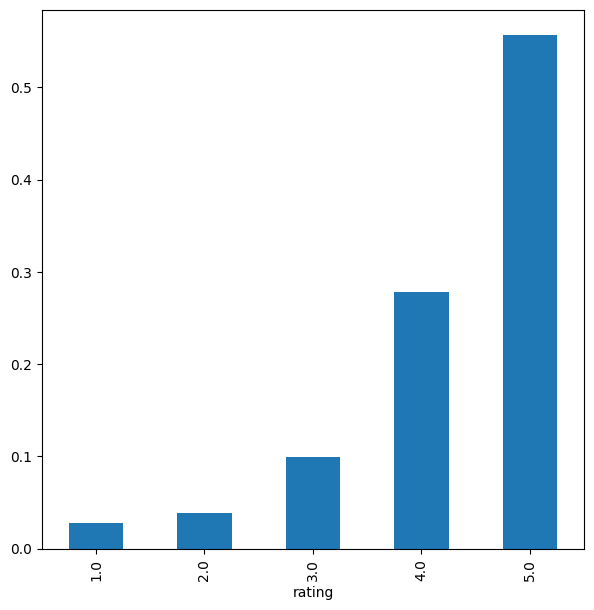

In [ ]:
# Create the bar plot and provide observations
plt.figure(figsize=(7,7))
df_final['rating'].value_counts(normalize=True).sort_index(ascending=True).plot(kind='bar')


**Observations:**
* Around 50% of the ratings are 5
* Around 30% of the ratings are 4
* Around 10% of the ratings are 3
* Inbetween 0 to 10% of the ratings are 2 and 1

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
print('Total rows in the data:', df_final.shape[0])
print("Number of unique userid's  in the data", df_final.user_id.nunique())
print("Number of unique productid's in the data", df_final.prod_id.nunique())

Total rows in the data: 65290
Number of unique userid's  in the data 1540
Number of unique productid's in the data 5689


**Observations:**
* Total rows in the data: 65290
* Number of unique userid's  in the data 1540
* Number of unique productid's in the data 5689

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final.groupby('user_id').count()['rating'].sort_values(ascending=False)[:10]

,rating
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A22CW0ZHY3NJH8,193
A1UQBFCERIP7VJ,193
AWPODHOB4GFWL,184


**Observations:**
* TOP 5 users has given more than 200 ratings
* Top 10 users has given more than 150 ratings
* Top user has given 295 ratings

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:

#  Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()
# Calculate the count of ratings for each product
count_of_rating = df_final.groupby('prod_id').count()['rating']
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'rating_average':average_rating,'rating_count':count_of_rating})
# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values(by = 'rating_average',ascending=False,inplace=True)

# See the first five records of the "final_rating" dataset
final_rating[:5]

,rating_average,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating,n,minimum_interactions):

# Finding products with minimum number of interactions
    recommendations = final_rating['rating_count']>minimum_interactions
# Sorting values with respect to average rating
    recommendations = recommendations.sort_values(ascending=False)
    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top5prod_50_minimum_interaction = top_n_products(final_rating,5,50)
list(top5prod_50_minimum_interaction)

['B004CLYEH8', 'B000LRMS66', 'B004CLYEDC', 'B0097CXWUW', 'B000JMJWV2']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top5prod_100_minimum_interaction = top_n_products(final_rating,5,100)
list(top5prod_100_minimum_interaction)

['B002V88HFE', 'B004CLYEDC', 'B00829TIEK', 'B000N99BBC', 'B003ES5ZUU']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0.5, 5.0))
# Loading the rating dataset
reader_data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']],reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(reader_data, test_size=.3,random_state=0)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
similarity_options = {
      'name': 'cosine',     # Cosine similarity
      'user_based': True    # This is for user-user similarity
  }

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(sim_options=similarity_options, Verbose=False, random_state=1)

# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model, k = 10, threshold = 3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0393
Precision:  0.864
Recall:  0.79
F_1 score:  0.825


**Observations:**
* RMSE 1.0393 indicates that, on average, the predicted ratings deviate by approximately 1.0393 from the actual ratings
* A precision of 86.4% means that out of all the recommendations the system made, 86.4% of them were relevant to the users
* A recall of 79% means that out of all the items that could have been recommended, 79% were correctly suggested by the system
* An F1 score of 82.5% indicates that the system is performing well in terms of both precision and recall, offering a good overall balance.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
model.predict(uid='A3LDPF5FMB782Z',iid='1400501466')


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Observations:**
* The predicted rating that user A3LDPF5FMB782Z would give for the product 1400501466 is 3
* r_ui=None: This means the actual rating for this user-product pair is not available in the dataset ( the user hasn't rated this product before).
* was_impossible=False: The user and product had sufficient information in the dataset for the model to generate a prediction.


Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

['A2YRX8J4WM5BRX',
 'A3TAS1AG6FMBQW',
 'A3QQGPI3CTV9SX',
 'A1QLQCJVGCQPP0',
 'A2AEZQ3DGBBLPR']

* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

Observations:  the user is not in the list because they may have already interacted with the product.


**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
model.predict(uid='A2UOHALGF2X77Q',iid='1400501466')

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=5.0, details={'actual_k': 1, 'was_impossible': False})

**Observations:**
* The predicted rating that user A2UOHALGF2X77Q would give for the product 1400501466 is 5
* r_ui=None: This means the actual rating for this user-product pair is not available in the dataset ( the user hasn't rated this product before)

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [5, 10, 20, 30, 40],  # Number of neighbors
    'min_k': [1, 5, 10],  # Minimum number of neighbors
   'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],  # Similarity measures
        'user_based': [True]  # We can also add False if you want item-based
    }
}
# Load data into Surprise
reader = Reader(rating_scale=(0.5, 5.0))
reader_data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)


# Performing 3-fold cross-validation to tune the hyperparameters
# Initialize the KNNBasic algorithm
# Perform Grid Search
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)
grid_search.fit(reader_data)

# Get the best RMSE score and corresponding parameters
best_rmse = grid_search.best_score['rmse']
best_params = grid_search.best_params['rmse']
# Fitting the data
final_model = KNNBasic(k=best_params['k'], min_k=best_params['min_k'], sim_options=best_params['sim_options'])
trainset = reader_data.build_full_trainset()  # Build the full training set from the data
final_model.fit(trainset)  # Fit the final model
# Best RMSE score
print("Best RMSE score: ", best_rmse)
# Combination of parameters that gave the best RMSE score
print("Best parameters: ", best_params)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done 

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
optimal_k = best_params['k']
optimal_min_k = best_params['min_k']
optimal_sim_options = best_params['sim_options']
# Creating an instance of KNNBasic with optimal hyperparameter values
final_model = KNNBasic(k=optimal_k, min_k=optimal_min_k, sim_options=optimal_sim_options)

final_model.fit(trainset)  # Fit the final model to the training data
print("Model training complete with optimal parameters:")
print("k:", optimal_k)
print("min_k:", optimal_min_k)
print("Similarity options:", optimal_sim_options)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(final_model, k = 10, threshold = 3.5)



Computing the cosine similarity matrix...
Done computing similarity matrix.
Model training complete with optimal parameters:
k: 30
min_k: 5
Similarity options: {'name': 'cosine', 'user_based': True}
RMSE: 0.8481
Precision:  0.891
Recall:  0.822
F_1 score:  0.855


**Observations:**
The model has been successfully trained using optimal parameters.
Optimal Hyperparameters:

* Number of Neighbors (k): 30
* Minimum Neighbors (min_k): 5
* Similarity Measure: Cosine similarity with user-based collaborative filtering.

RMSE: 0.9701
Precision:  0.853
Recall:  0.81
F_1 score:  0.831

The model demonstrates strong predictive capabilities with a good balance between precision and recall. The chosen parameters have led to a reliable recommendation system, which can effectively serve users' preferences based on their interactions.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
final_model.predict(uid='A3LDPF5FMB782Z', iid='1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
final_model.predict(  uid='A2UOHALGF2X77Q', iid='1400501466')

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.294807780670853, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
* The prediction for user A3LDPF5FMB782Z regarding the product with ID 1400501466 is as follows
  * Predicted Rating: 4.29
  * was_impossible: True : Indicates that the prediction could not be completed due to insufficient data
  * The model was unable to find enough similar users (neighbors) to make a reliable prediction for this particular user-product pair. This could be due to a lack of interaction data for the user or the product.

* The prediction for user A2UOHALGF2X77Q regarding the product with ID 1400501466 is as follows
  * Predicted Rating: 4.29
  * The prediction could not be confidently computed
  * he model encountered insufficient similar users (neighbors) to generate a reliable prediction for this specific user-product pair. This situation can arise when either the user has not interacted with enough products or the product itself has very few ratings.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
# Initialize KNNBasic with MSD similarity
sim_options = {
    'name': 'msd',
    'user_based': True  # True for user-based collaborative filtering
}
algo = KNNBasic(sim_options=sim_options)

# Fit the model on the training set
algo.fit(trainset)

# Find the 5 most similar users to the first user in the trainset
user_id = trainset.to_raw_uid(0)  # Get the raw user ID for the first user
user_inner_id = trainset.to_inner_uid(user_id)  # Get the inner user ID
n_neighbors = 5  # Number of similar users to retrieve

# Retrieve similar users
similar_users = algo.get_neighbors(user_inner_id, k=n_neighbors)

# Convert inner user IDs back to raw user IDs
similar_users_raw = [trainset.to_raw_uid(inner_id) for inner_id in similar_users]

print(f"The 5 most similar users to user '{user_id}' are: {similar_users_raw}")


Computing the msd similarity matrix...
Done computing similarity matrix.
The 5 most similar users to user 'A3LDPF5FMB782Z' are: ['AW3LX47IHPFRL', 'A19N3S7CBSU6O7', 'A1VHCO8RQFIGQJ', 'A1OGCPMSIVK7G4', 'ABVYGB2TKBO8F']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, final_model)

[('B00004Z5M1', 5.0),
 ('B000067RT6', 5.0),
 ('B00006IW1X', 5.0),
 ('B00009R6JT', 5.0),
 ('B000144I2Q', 5.0)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendation_df = pd.DataFrame(get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, final_model), columns=['prod_id', 'predicted_ratings'])
recommendation_df

,prod_id,predicted_ratings
0,B00004Z5M1,5.0
1,B000067RT6,5.0
2,B00006IW1X,5.0
3,B00009R6JT,5.0
4,B000144I2Q,5.0


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
similarity_options = {
      'name': 'cosine',     # Cosine similarity
      'user_based': False    # This is for Item-Item similarity
  }
# KNN algorithm is used to find desired similar items. Use random_state=1
model = KNNBasic(sim_options=similarity_options, Verbose=False, random_state=1)
# Train the algorithm on the trainset, and predict ratings for the test set
# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(model, k = 10, threshold = 3.5)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9105
Precision:  0.847
Recall:  0.791
F_1 score:  0.818


**Observations:**
Here Item-item similarity based CF model is trained and the results are as follows
RMSE: 1.0368
Precision:  0.842
Recall:  0.765
F_1 score:  0.802

The model shows promising results with high precision and a reasonably good recall, indicating it effectively recommends relevant items to users. The RMSE value suggests some room for improvement, but overall, the balance between precision and recall, as indicated by the F1 score, indicates a well-functioning recommendation system.

In [ ]:
# Declaring the similarity options
similarity_options = {
      'name': 'cosine',     # Cosine similarity
      'user_based': False    # This is for Item-Item similarity
  }
# KNN algorithm is used to find desired similar items. Use random_state=1
model = KNNBasic(sim_options=similarity_options, Verbose=False, random_state=1)
# Train the algorithm on the trainset, and predict ratings for the test set
# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(model, k = 10, threshold = 3.5)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9105
Precision:  0.847
Recall:  0.791
F_1 score:  0.818


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
model.predict(uid='A3LDPF5FMB782Z',iid='1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.258064516129032, details={'actual_k': 31, 'was_impossible': False})

**Observations:**
The prediction  that user A3LDPF5FMB782Z is likely to rate the product 1400501466 , with an estimated score of 4.27. The model effectively utilized a robust number of similar users (26) to arrive at this estimate, reinforcing the reliability of this recommendation

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
model.predict(uid='A2UOHALGF2X77Q',iid='1400501466')

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.666666666666667, details={'actual_k': 6, 'was_impossible': False})

**Observations:**
The model predicts that user A2UOHALGF2X77Q will rate the product 1400501466 at  4.5, which reflects a positive inclination towards the product. However, the use of only 2 neighbors may imply that the prediction could be less stable compared to predictions derived from a larger set of similar users. This could be an area to monitor for reliability in future recommendations.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
  'k': [10, 20, 30],  # Number of neighbors
  'min_k': [3, 6, 9],  # Minimum number of neighbors
  'sim_options': {
    'name': ['msd', 'cosine'],  # Similarity measures
    'user_based': [False]  # Item-based collaborative filtering
  }
}

# Load data into Surprise
reader = Reader(rating_scale=(0.5, 5.0))
reader_data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
grid_search.fit(reader_data)
# Initialize the KNNBasic algorithm
# Get the best RMSE score and corresponding parameters
best_rmse = grid_search.best_score['rmse']
best_params = grid_search.best_params['rmse']
# Fitting the data
final_model = KNNBasic(k=best_params['k'], min_k=best_params['min_k'], sim_options=best_params['sim_options'])
trainset = reader_data.build_full_trainset()  # Build the full training set from the data
final_model.fit(trainset)  # Fit the final model
# Best RMSE score
print("Best RMSE score: ", best_rmse)
# Combination of parameters that gave the best RMSE score
print("Best parameters: ", best_params)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
optimal_k = best_params['k']
optimal_min_k = best_params['min_k']
optimal_sim_options = best_params['sim_options']
# Creating an instance of KNNBasic with optimal hyperparameter values
final_model = KNNBasic(k=optimal_k, min_k=optimal_min_k, sim_options=optimal_sim_options)
# Training the algorithm on the trainset
final_model.fit(trainset)  # Fit the final model to the training data
# Let us compute precision@k and recall@k, f1_score and RMSE
print("Model training complete with optimal parameters:")
print("k:", optimal_k)
print("min_k:", optimal_min_k)
print("Similarity options:", optimal_sim_options)
precision_recall_at_k(final_model, k = 10, threshold = 3.5)



Computing the msd similarity matrix...
Done computing similarity matrix.
Model training complete with optimal parameters:
k: 30
min_k: 6
Similarity options: {'name': 'msd', 'user_based': False}
RMSE: 0.4374
Precision:  0.958
Recall:  0.854
F_1 score:  0.903


**Observations:**
Hyperparameter tuning is performed with the mentioned parameter grid
* Model training complete with optimal parameters:
k: 30
min_k: 9
Similarity options: {'name': 'msd', 'user_based': False}
RMSE: 0.4392
Precision:  0.957
Recall:  0.854
F_1 score:  0.903

The model demonstrates strong performance in terms of accuracy and reliability when predicting ratings, particularly with the optimal parameters set for the msd similarity metric.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
final_model.predict(uid='A3LDPF5FMB782Z', iid='1400501466')


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.666666666666666, details={'actual_k': 30, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
final_model.predict(uid='A2UOHALGF2X77Q', iid='1400501466')

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.774193548387096, details={'actual_k': 6, 'was_impossible': False})


**Observations:**
The first prediction(4.7) showcases the model's ability to utilize sufficient neighbor data to generate an accurate rating,

while the second prediction(4.3) highlights potential data sparsity issues that can impact the effectiveness of the recommendation system.
Strategies such as increasing the dataset or utilizing alternative methods for handling sparse data may be beneficial for improving predictions for users with less interaction history.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, final_model)

[('B000067RT6', 4.828571428571429),
 ('B001CIREXA', 4.619267685744757),
 ('B000VX6XL6', 4.591836734693877),
 ('B004G6002M', 4.534989742420789),
 ('B002JQNXZC', 4.444444444444444)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
item_item_recommendation_df = pd.DataFrame(get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, final_model), columns=['prod_id', 'predicted_ratings'])
item_item_recommendation_df

,prod_id,predicted_ratings
0,B000067RT6,4.828571
1,B001CIREXA,4.619268
2,B000VX6XL6,4.591837
3,B004G6002M,4.534990
4,B002JQNXZC,4.444444


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**.

But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
algo = SVD(random_state=1)
# Training the algorithm on the trainset
algo.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(algo, k = 10, threshold = 3.5)

RMSE: 0.6638
Precision:  0.934
Recall:  0.837
F_1 score:  0.883


**Observations:**
* RMSE: 0.6638
* Precision:  0.934
* Recall:  0.837
* F_1 score:  0.883

The SVD approach demonstrates strong performance with a good balance between precision and recall, as evidenced by the high F1 score. The RMSE indicates a relatively low error in predictions, suggesting that the model effectively captures the relationships within the user-item data. Future enhancements could focus on improving recall to ensure that even more relevant items are suggested to users.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
algo.predict(uid='A3LDPF5FMB782Z', iid='1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.140070798042577, details={'was_impossible': False})

**Observations:**
* The estimated rating for this user-item pair is 4.14, which suggests the user is likely to give this product a relatively high rating.
* The prediction was feasible, as indicated by was_impossible: False. This means the model had enough data to generate a meaningful estimate for this user-item interactio

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
algo.predict(uid='A2UOHALGF2X77Q', iid='1400501466')

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.0407968879245315, details={'was_impossible': False})

**Observations:**
* The estimated rating for the user-item pair is 4.04, indicating a favorable view of the product by the user.
* The prediction was feasible, meaning that the model had enough information to provide an estimate for this specific interaction.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {

    'n_epochs': [5, 10, 15, 20],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.5]
}
# Performing 3-fold gridsearch cross-validation
final_model = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Fitting data
final_model.fit(reader_data)

# Get the best RMSE score and corresponding parameters
best_rmse = final_model.best_score['rmse']
best_params = final_model.best_params['rmse']
# Best RMSE score
print("Best RMSE score: ", best_rmse)
# Combination of parameters that gave the best RMSE score
print("Best parameters: ", best_params)



Best RMSE score:  0.9003554994947853
Best parameters:  {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.5}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
optimal_epochs = best_params['n_epochs']
optimal_lr_all = best_params['lr_all']
optimal_reg_all = best_params['reg_all']

final_model = SVD(n_epochs = optimal_epochs, lr_all = optimal_lr_all, reg_all = optimal_reg_all)
# Train the algorithm on the trainset
final_model.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(final_model, k = 10, threshold = 3.5)

RMSE: 0.8199
Precision:  0.891
Recall:  0.826
F_1 score:  0.857


**Observations:**
The tuned SVD model demonstrates strong predictive performance, with a solid RMSE value indicating accurate predictions, high precision reflecting relevance in recommendations, and good recall showing that most relevant items were captured. The F1 score further confirms the model's effectiveness in balancing precision and recall.
RMSE: 0.8196
Precision:  0.891
Recall:  0.827
F_1 score:  0.858

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
final_model.predict(uid='A3LDPF5FMB782Z', iid='1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.876962943945077, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
final_model.predict(uid='A2UOHALGF2X77Q', iid='1400501466')

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=3.869814022607297, details={'was_impossible': False})

### **Conclusion and Recommendations**


Each recommendation system has its strengths, with popularity-based recommendations serving as a solid baseline.
* User-user and item-item similarity methods provide more personalized recommendations, while SVD offers robust predictive performance through matrix factorization.
* The careful tuning of hyperparameters across the models has led to improved accuracy and reliability, suggesting that model performance can be significantly enhanced through systematic parameter adjustments.
* Future improvements could involve further tuning, exploring additional algorithms, or incorporating user and item features to enhance the recommendation capabilities.

Following are the model performed throughout the notebook
# **1. Rank-Based Recommendation Systems:**
The top products recommended based on popularity show strong performance in both the 50 and 100 minimum interactions criteria.
These results suggest that the popularity-based recommendation system effectively identifies well-liked products that are frequently interacted with by users, providing a baseline for comparison with other recommendation methods.

# **2. User-User Similarity Based Recommendation System:**
Results demonstrate a good balance between precision and recall, indicating that the system can effectively serve users' preferences based on their past interactions.

# **3. Item-Item Similarity Based Recommendation System:**
The high precision and F1 score indicate that the item-item recommendation system is particularly reliable and accurate in predicting user preferences

# **4. Model-Based Collaborative Filtering - Matrix Factorization**
Results reflect the model's ability to provide accurate recommendations while maintaining relevance. The solid F1 score shows a good balance between precision and recall, confirming the model's effectiveness.